<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Return-manager-for-simulation" data-toc-modified-id="Return-manager-for-simulation-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>Return manager for simulation</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Persistent-vs-Sequential-Activity" data-toc-modified-id="Persistent-vs-Sequential-Activity-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Persistent vs Sequential Activity</a></span><ul class="toc-item"><li><span><a href="#An-example" data-toc-modified-id="An-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>An example</a></span></li><li><span><a href="#Systematic" data-toc-modified-id="Systematic-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Systematic</a></span><ul class="toc-item"><li><span><a href="#Single-example" data-toc-modified-id="Single-example-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Single example</a></span></li><li><span><a href="#Variation-with-IPI" data-toc-modified-id="Variation-with-IPI-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Variation with IPI</a></span></li><li><span><a href="#Tau_z_vector-and-IPI" data-toc-modified-id="Tau_z_vector-and-IPI-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>Tau_z_vector and IPI</a></span></li><li><span><a href="#IPI-and-Training-time" data-toc-modified-id="IPI-and-Training-time-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>IPI and Training time</a></span></li></ul></li></ul></li><li><span><a href="#Graph" data-toc-modified-id="Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Graph</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#First-the-calculation-of-the-matrix" data-toc-modified-id="First-the-calculation-of-the-matrix-3.0.1"><span class="toc-item-num">3.0.1&nbsp;&nbsp;</span>First the calculation of the matrix</a></span></li></ul></li><li><span><a href="#Get-the-graphs-together" data-toc-modified-id="Get-the-graphs-together-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Get the graphs together</a></span></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities, calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Parameters

In [2]:
epsilon = 1e-7
vmin = -6.0
remove = 0.010

strict_maximum = True

dt = 0.001
tau_s = 0.010
tau_a = 0.250
g_I = 2.0
g_a = 2.0
G = 50.0

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['figure.figsize'] = (12, 8)
lw = 10
ms = 22
alpha_graph = 0.3
colors = sns.color_palette()

## Functions

#### Return manager for simulation

In [3]:
def return_manager_from_simulation(ipi, tau_z_pre, T_per, sigma=0.0):
    
    print('ipi', ipi)
    print('tau_z_pre', tau_z_pre)
    print('sigma', sigma)

    sigma_out = sigma
    tau_z_pre = tau_z_pre
    tau_z_post = 0.005

    hypercolumns = 1
    minicolumns = 10
    n_patterns = minicolumns


    # Training protocol
    training_times_base = 0.100
    training_times = [training_times_base for i in range(n_patterns)]
    ipi_base = ipi
    inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
    inter_sequence_interval = 1.0
    resting_time = 0.0
    epochs = 1
    T_persistence = T_per
    
    # Manager properties
    values_to_save = ['o']


    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                     tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                     strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                        inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)
    # Set the persistent time
    manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)
    
    return manager

# Persistent vs Sequential Activity

## An example

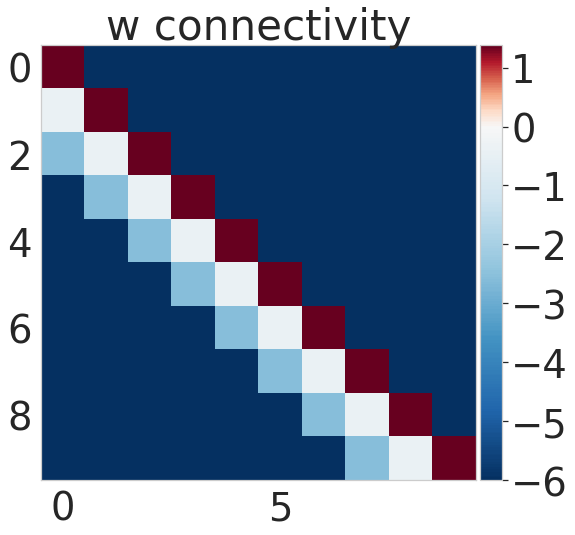

In [4]:
sigma_out = 0.01
tau_z_pre = 0.100
tau_z_post = 0.005

hypercolumns = 1
minicolumns = 10
n_patterns = minicolumns


# Training protocol
training_times_base = 0.100
training_times = [training_times_base for i in range(n_patterns)]
ipi_base = 0.400
inter_pulse_intervals = [ipi_base for i in range(n_patterns)]
inter_sequence_interval = 1.0
resting_time = 1.0
epochs = 1
T_persistence = 0.100

# Manager properties
values_to_save = ['o']


# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation, minicolumns=minicolumns)


# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals,
                    inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
# Set the persistent time
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence, from_state=1, to_state=2)

plot_weight_matrix(manager, vmin=vmin)

success 1.0
pattern sequence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
times [0.1, 0.1, 0.101, 0.101, 0.1, 0.10200000000000001, 0.099, 0.099, 0.101, 0.125]
T_calculated 0.100375


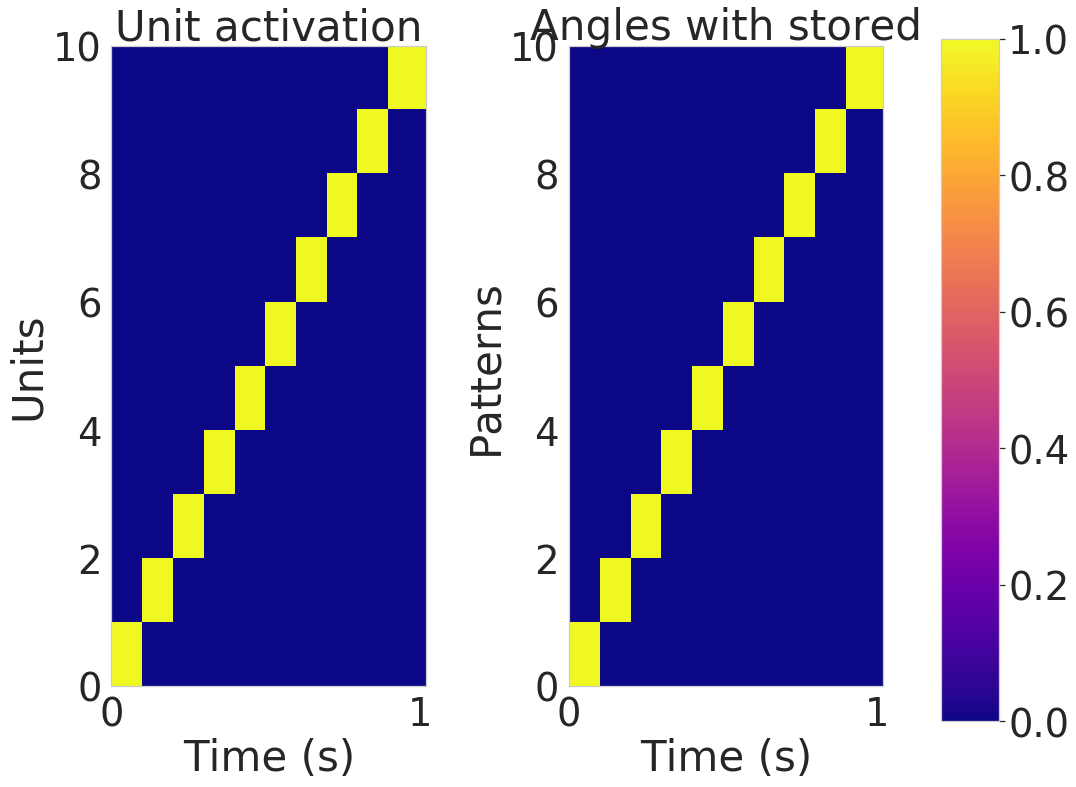

In [5]:
T_cue = 1.0 * manager.nn.tau_s
T_recall = T_persistence * n_patterns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux

print('success', success)
print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False);

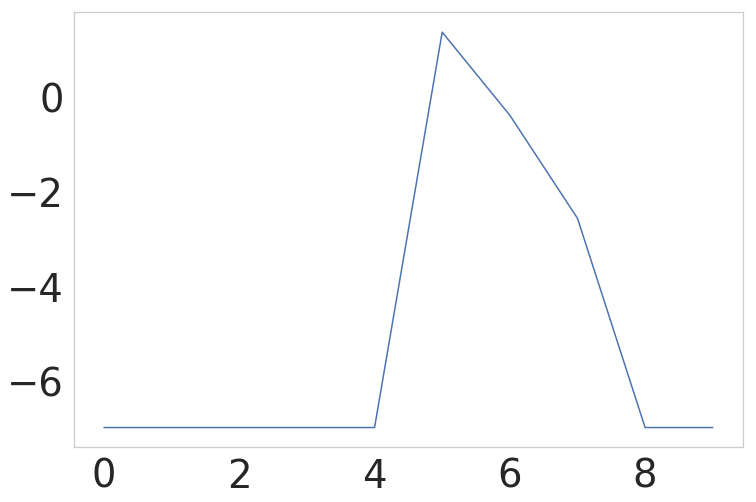

In [6]:
plt.plot(nn.w[:, 5])

## Systematic

Some calculations
In order for a probability to be discard-able from the system it needs to be relatively small compared to some reasonable expectation for probability. We get this by considering that the smallest time that unit could be active is around ~10ms. This set the nominator for the smallest probability. Now the denominator is unbounded but here we set some reasonable amounts that could be used.

* An hour = 60 * 60 * 1000 ms
* A day = 24* 60 * 60 * 1000 ms
* A year = 364 * 60 * 60 * 1000 ms
* A lifetime 75 * 364 * 60* 60 * 1000 ms

Lets calculate this quantities bellow

In [7]:
minimal_event = 10 

second  = 1000
minute = 60 * second 
hour = 60 * minute
day = 24 * hour
year = 364 * day
lifetime = 75 * year


x = lifetime
f"{x:.2e}"

'2.36e+12'

In [8]:
second_time = minimal_event / second
minute_time = minimal_event / minute 
hour_time = minimal_event /  hour
day_time = minimal_event / day 
year_time = minimal_event / year
lifetime_time = minimal_event / lifetime

print('second', second_time)
print('minute', minute_time)
print('hour', hour_time)
print('day', day_time)
print('year', year_time)
print('lifetime', lifetime_time)

second 0.01
minute 0.00016666666666666666
hour 2.777777777777778e-06
day 1.1574074074074074e-07
year 3.17969067969068e-10
lifetime 4.2395875729209065e-12


### Single example

In [9]:
from analysis_functions import calculate_joint_probabilities_theo
tt1 = 0.100
ipi1 = 0.0
tau_z_pre = 0.100
tau_z_post = 0.005
Ts = tt1 + ipi1
Tt = n_patterns * tt1 + (n_patterns - 1) * ipi1
tt2 = tt1
p_joint = calculate_joint_probabilities_theo(T1=tt1, Ts=Ts, T2=tt2, Tt=Tt, tau1=tau_z_pre, tau2=tau_z_post)
print('p_joint', p_joint)

p_joint 0.03805489532321219


### Variation with IPI

In [10]:
tt1 = 0.100
ipi1 = 0.0
tau_z_pre = 0.100
tau_z_post = 0.005

num = 20
ipi_vector = np.linspace(0, 0.250, num=num)
p_joint_vector = np.zeros(num)

for index, ipi1 in enumerate(ipi_vector):
    Ts = tt1 + ipi1
    Tt = n_patterns * tt1 + (n_patterns - 1) * ipi1
    p_joint = calculate_joint_probabilities_theo(T1=tt1, Ts=Ts, T2=tt2, Tt=Tt, tau1=tau_z_pre, tau2=tau_z_post)
    p_joint_vector[index] = p_joint

Text(0,0.5,'$p_{ij}$')

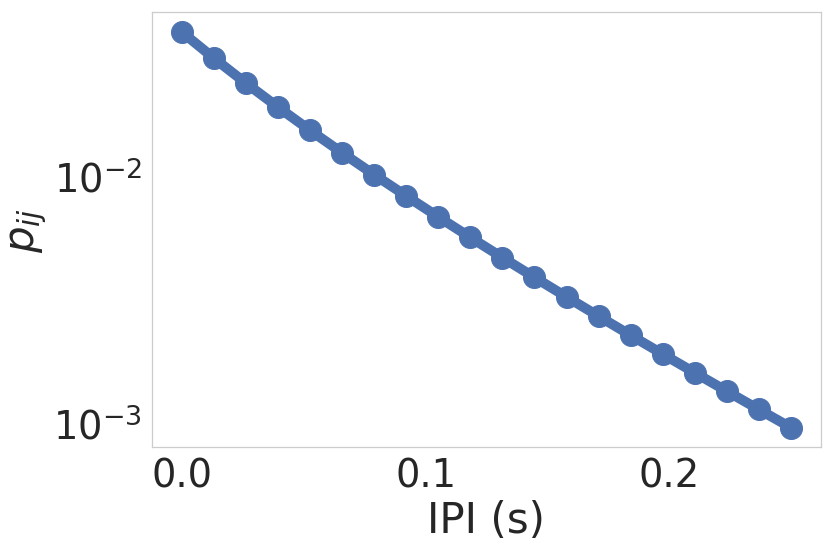

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ipi_vector, p_joint_vector, 'o-', ms=ms, lw=lw)
ax.set_yscale('log', basey=10)
ax.set_xlabel('IPI (s)')
ax.set_ylabel(r'$p_{ij}$')

In [12]:
tau_z_pre_set = [0.005, 0.025, 0.050, 0.100]
p_joint_set = []

tt1 = 0.100
ipi1 = 0.0
tau_z_pre = 0.005
tau_z_post = 0.005

num = 20

for tau_z_pre in tau_z_pre_set:

    ipi_vector = np.linspace(0, 0.250, num=num)
    p_joint_vector = np.zeros(num)

    for index, ipi1 in enumerate(ipi_vector):
        Ts = tt1 + ipi1
        Tt = n_patterns * tt1 + (n_patterns - 1) * ipi1
        p_joint = calculate_joint_probabilities_theo(T1=tt1, Ts=Ts, T2=tt2, Tt=Tt, tau1=tau_z_pre, tau2=tau_z_post)
        p_joint_vector[index] = p_joint
        
    p_joint_set.append(np.copy(p_joint_vector))

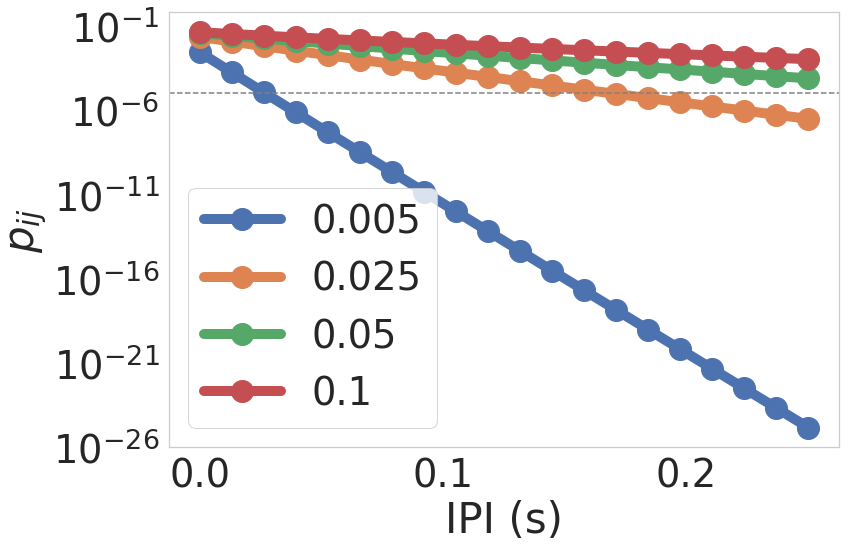

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

for index, p_joint_vector in enumerate(p_joint_set):
    ax.plot(ipi_vector, p_joint_vector, 'o-', ms=ms, lw=lw, label=str(tau_z_pre_set[index]))
ax.set_yscale('log', basey=10)
ax.set_xlabel('IPI (s)')
ax.set_ylabel(r'$p_{ij}$')

ax.axhline(10e-6, ls='--', color='gray')
ax.legend();

### Tau_z_vector and IPI

In [14]:
%%time

num = 20
num_z = 20
tau_z_post = 0.005
tt1 = 0.100
tt2 = tt1
ipi_vector = np.linspace(0, 0.500, num=num)
tau_z_pre_vector = np.linspace(0.005, 0.150, num=num_z)
p_joint_matrix = np.zeros((num, num_z))

for index_ipi, ipi1 in enumerate(ipi_vector):
    for index_tau_z, tau_z_pre in enumerate(tau_z_pre_vector):
        Ts = tt1 + ipi1
        Tt = n_patterns * tt1 + (n_patterns - 1) * ipi1
        p_joint = calculate_joint_probabilities_theo(T1=tt1, Ts=Ts, T2=tt2, Tt=Tt, tau1=tau_z_pre, tau2=tau_z_post)
        p_joint_matrix[index_ipi, index_tau_z] = p_joint

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.18 ms


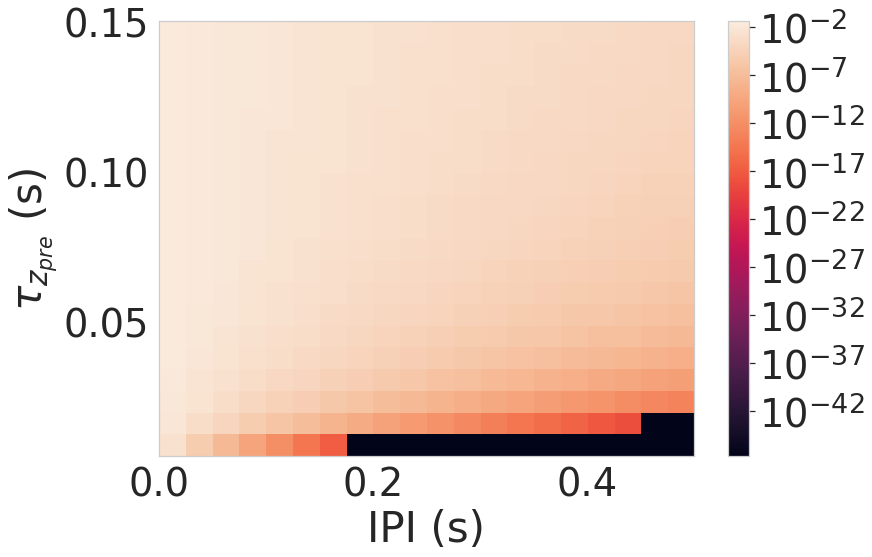

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
extent = [ipi_vector[0], ipi_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(p_joint_matrix.T, origin='lower', extent=extent, aspect='auto', 
               norm=matplotlib.colors.LogNorm())
ax.set_xlabel('IPI (s)')
ax.set_ylabel(r'$\tau_{z_{pre}}$ (s)')
fig.colorbar(im);

Let's mask this vector to see where it actually succeds

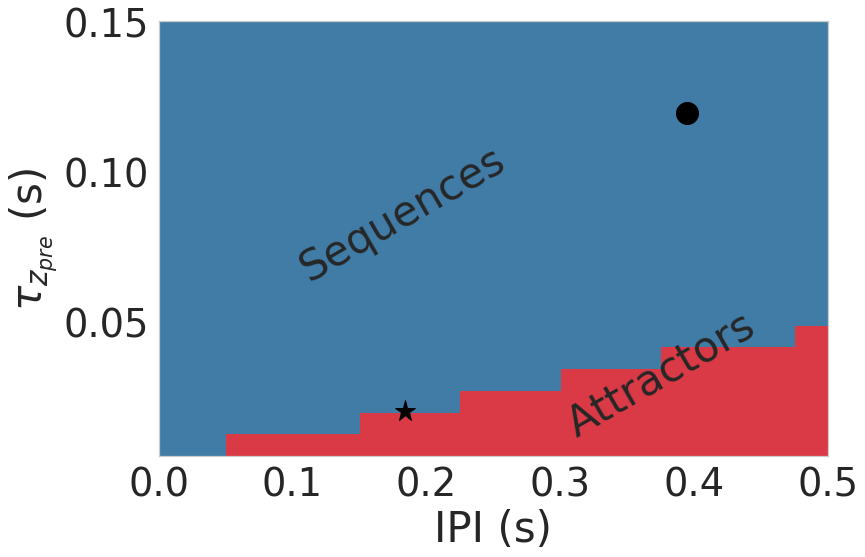

In [16]:
success_matrix = np.zeros((num, num_z))
success_matrix[p_joint_matrix <= epsilon] = 1.0
success_matrix[p_joint_matrix > epsilon] = 0.0

cmap = plt.cm.get_cmap('bwr_r', 2)
cmap = sns.diverging_palette(240, 10, n=2, as_cmap=True)

fig = plt.figure()
ax = fig.add_subplot(111)
extent = [ipi_vector[0], ipi_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(success_matrix.T, origin='lower', extent=extent, aspect='auto', cmap=cmap)
ax.set_xlabel('IPI (s)')
ax.set_ylabel(r'$\tau_{z_{pre}}$ (s)')

angle = 30
ax.text(x=0.10, y=0.100, s='Sequences', rotation=angle)
ax.text(x=0.30, y=0.045, s='Attractors', rotation=angle)

ipi_point1 = ipi_vector[15]
tau_z_point1 = tau_z_pre_vector[15]
ipi_point2 = ipi_vector[7]
tau_z_point2 = tau_z_pre_vector[2]

ax.plot(ipi_point1, tau_z_point1, 'o', ms=ms, color='black')
ax.plot(ipi_point2, tau_z_point2, '*', ms=ms, color='black')


In [17]:
print(ipi_point1)
print(tau_z_point1)

0.39473684210526316
0.11947368421052632


In [18]:
print(ipi_point2)
print(tau_z_point2)

0.18421052631578946
0.02026315789473684


### IPI and Training time

In [19]:
%%time

num = 20
num2 = 20
tau_z_pre = 0.025
tau_z_post = 0.005
ipi_vector = np.linspace(0, 0.250, num=num)
training_times_vector = np.linspace(0.020, 1.0, num=num2)
p_joint_matrix = np.zeros((num, num2))

for index_ipi, ipi1 in enumerate(ipi_vector):
    for index2, tt1 in enumerate(training_times_vector):
        tt2 = tt1
        Ts = tt1 + ipi1
        Tt = n_patterns * tt1 + (n_patterns - 1) * ipi1
        p_joint = calculate_joint_probabilities_theo(T1=tt1, Ts=Ts, T2=tt2, Tt=Tt, tau1=tau_z_pre, tau2=tau_z_post)
        p_joint_matrix[index_ipi, index2] = p_joint

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 10.6 ms


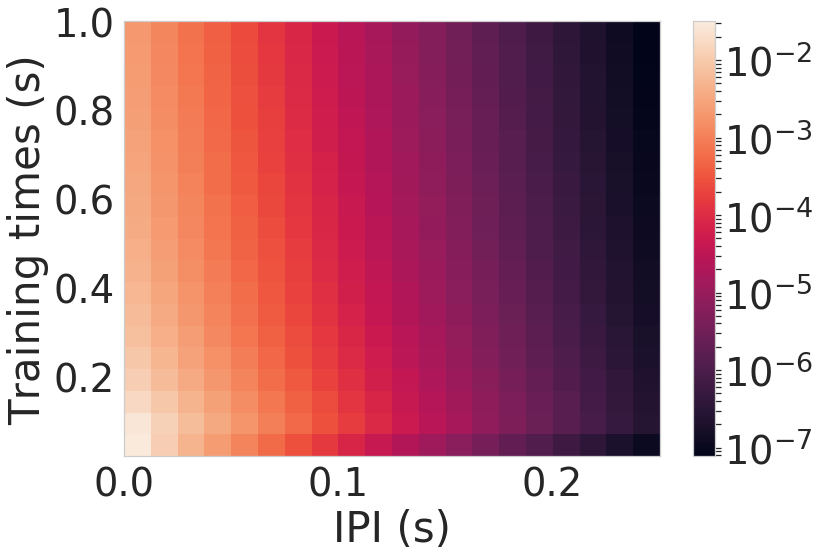

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
extent = [ipi_vector[0], ipi_vector[-1], training_times_vector[0], training_times_vector[-1]]

im = ax.imshow(p_joint_matrix.T , origin='lower', extent=extent, norm=matplotlib.colors.LogNorm(), aspect='auto')
ax.set_xlabel('IPI (s)')
ax.set_ylabel(r'Training times (s)')
fig.colorbar(im)

# Graph

### First the calculation of the matrix

In [21]:
%%time

num = 250
num_z = 250
tau_z_post = 0.005
tt1 = 0.100
tt2 = tt1
ipi_vector = np.linspace(0, 0.500, num=num)
tau_z_pre_vector = np.linspace(0.005, 0.150, num=num_z)
p_joint_matrix = np.zeros((num, num_z))

for index_ipi, ipi1 in enumerate(ipi_vector):
    for index_tau_z, tau_z_pre in enumerate(tau_z_pre_vector):
        Ts = tt1 + ipi1
        Tt = n_patterns * tt1 + (n_patterns - 1) * ipi1
        p_joint = calculate_joint_probabilities_theo(T1=tt1, Ts=Ts, T2=tt2, Tt=Tt, tau1=tau_z_pre, tau2=tau_z_post)
        p_joint_matrix[index_ipi, index_tau_z] = p_joint

CPU times: user 1.11 s, sys: 4 ms, total: 1.12 s
Wall time: 864 ms


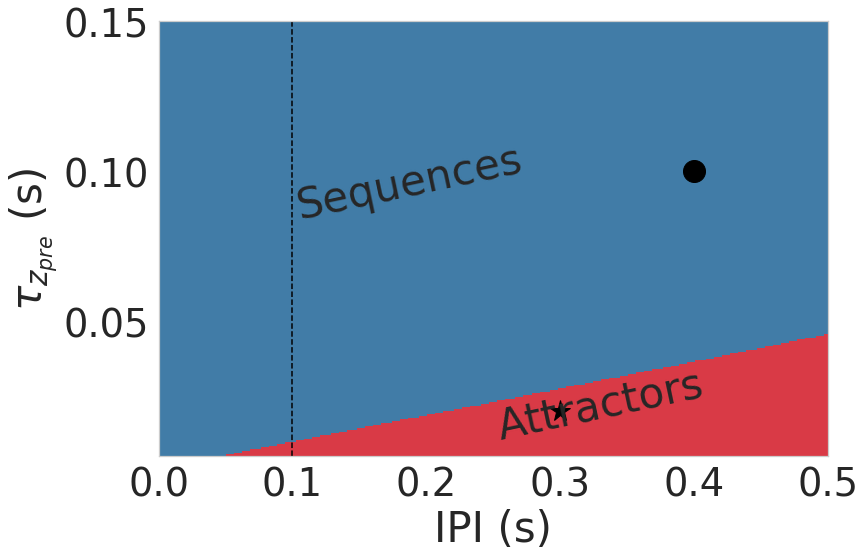

In [22]:
success_matrix = np.zeros((num, num_z))
success_matrix[p_joint_matrix <= epsilon] = 1.0
success_matrix[p_joint_matrix > epsilon] = 0.0

cmap = plt.cm.get_cmap('bwr_r', 2)
cmap = sns.diverging_palette(240, 10, n=2, as_cmap=True)

fig = plt.figure()
ax = fig.add_subplot(111)
extent = [ipi_vector[0], ipi_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]

im = ax.imshow(success_matrix.T, origin='lower', extent=extent, aspect='auto', cmap=cmap)
ax.set_xlabel('IPI (s)')
ax.set_ylabel(r'$\tau_{z_{pre}}$ (s)')

angle = 12
ax.text(x=0.100, y=0.100, s='Sequences', rotation=angle)
ax.text(x=0.250, y=0.025, s='Attractors', rotation=angle)

ipi_point1 = 0.400
tau_z_point1 = 0.100
ipi_point2 = 0.300
tau_z_point2 = 0.020

ax.plot(ipi_point1, tau_z_point1, 'o', ms=ms, color='black')
ax.plot(ipi_point2, tau_z_point2, '*', ms=ms, color='black')

ax.axvline(0.100, color='black', ls='--');

ipi 0.4
tau_z_pre 0.1
sigma 0.01
success 1.0
pattern sequence [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
times [0.098, 0.101, 0.099, 0.1, 0.099, 0.101, 0.101, 0.1, 0.1, 0.129]
T_calculated 0.100125


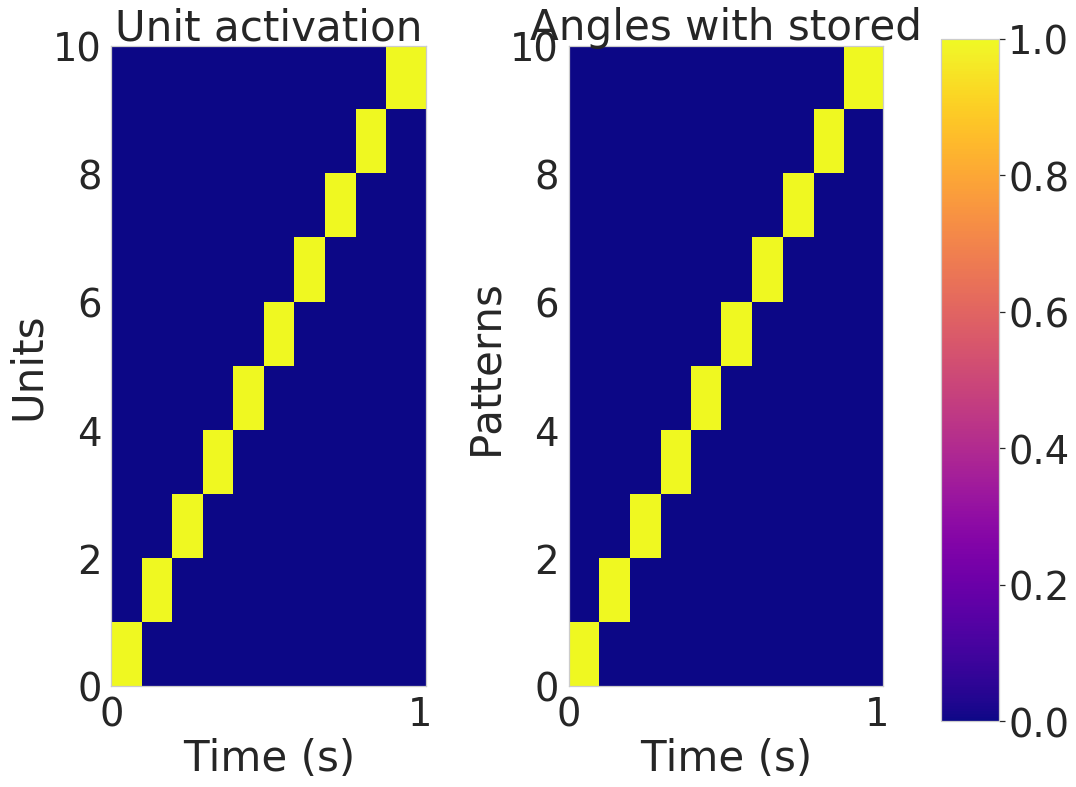

In [23]:
ipi = ipi_point1
tau_z_pre = tau_z_point1
manager = return_manager_from_simulation(ipi, tau_z_pre, T_per=0.100, sigma=0.01)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 0.100 * manager.nn.minicolumns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux
print('success', success)
print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
plot_network_activity_angle(manager, time_y=False)

O1 = np.copy(manager.history['o'])

ipi 0.3
tau_z_pre 0.02
sigma 0.01
success 0.0
pattern sequence [0, 2, 7, 1, 5, 8, 6, 3, 4, 9, 0]
times [0.099, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.101, 0.10400000000000001, 0.025]
T_calculated 0.10055555555555556


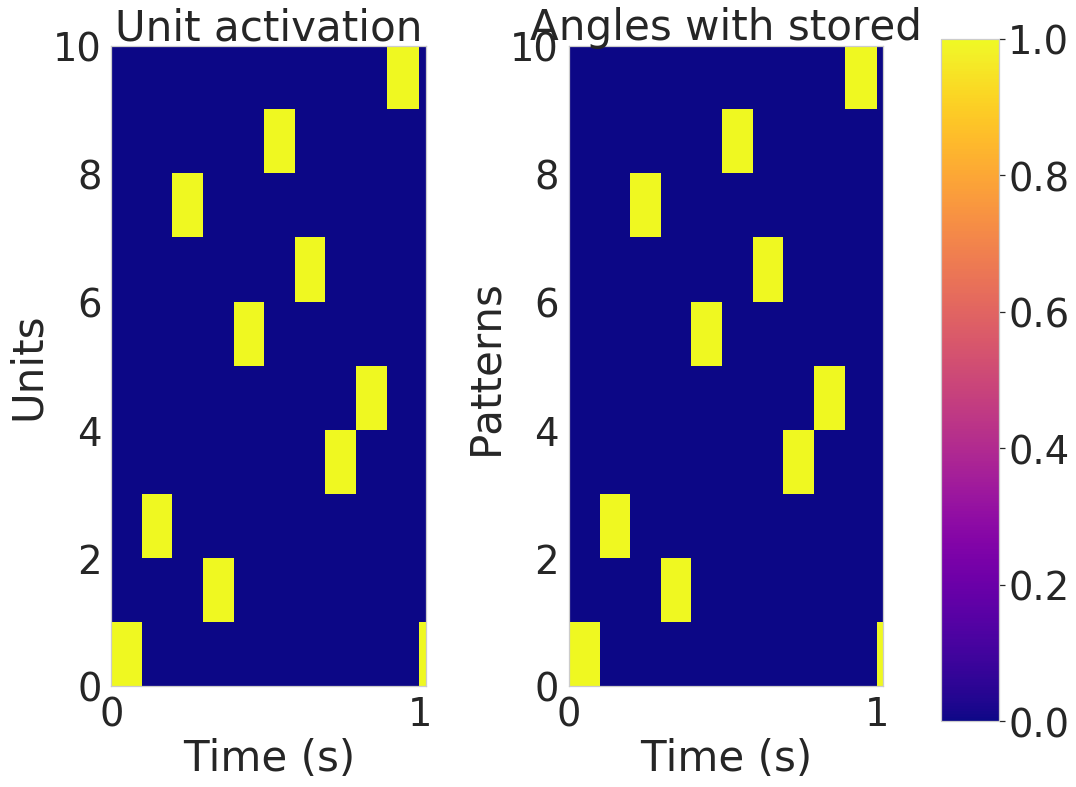

In [24]:
ipi = ipi_point2
tau_z_pre = tau_z_point2
#tau_z_pre = 0.025
#ipi = 0.0
manager = return_manager_from_simulation(ipi, tau_z_pre, T_per=0.100, sigma=0.01)

T_cue = 1.0 * manager.nn.tau_s
T_recall = 0.100 * manager.nn.minicolumns + T_cue

# Success
nr = representation.network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove, reset=True, empty_history=True)
success, pattern_sequence, persistent_times, timings = aux
print('success', success)
print('pattern sequence', pattern_sequence)
print('times', persistent_times)
print('T_calculated', np.mean(persistent_times[1:-1]))
ax_aux , ax_point2 = plot_network_activity_angle(manager, time_y=False)

O2 = np.copy(manager.history['o'])

## Get the graphs together

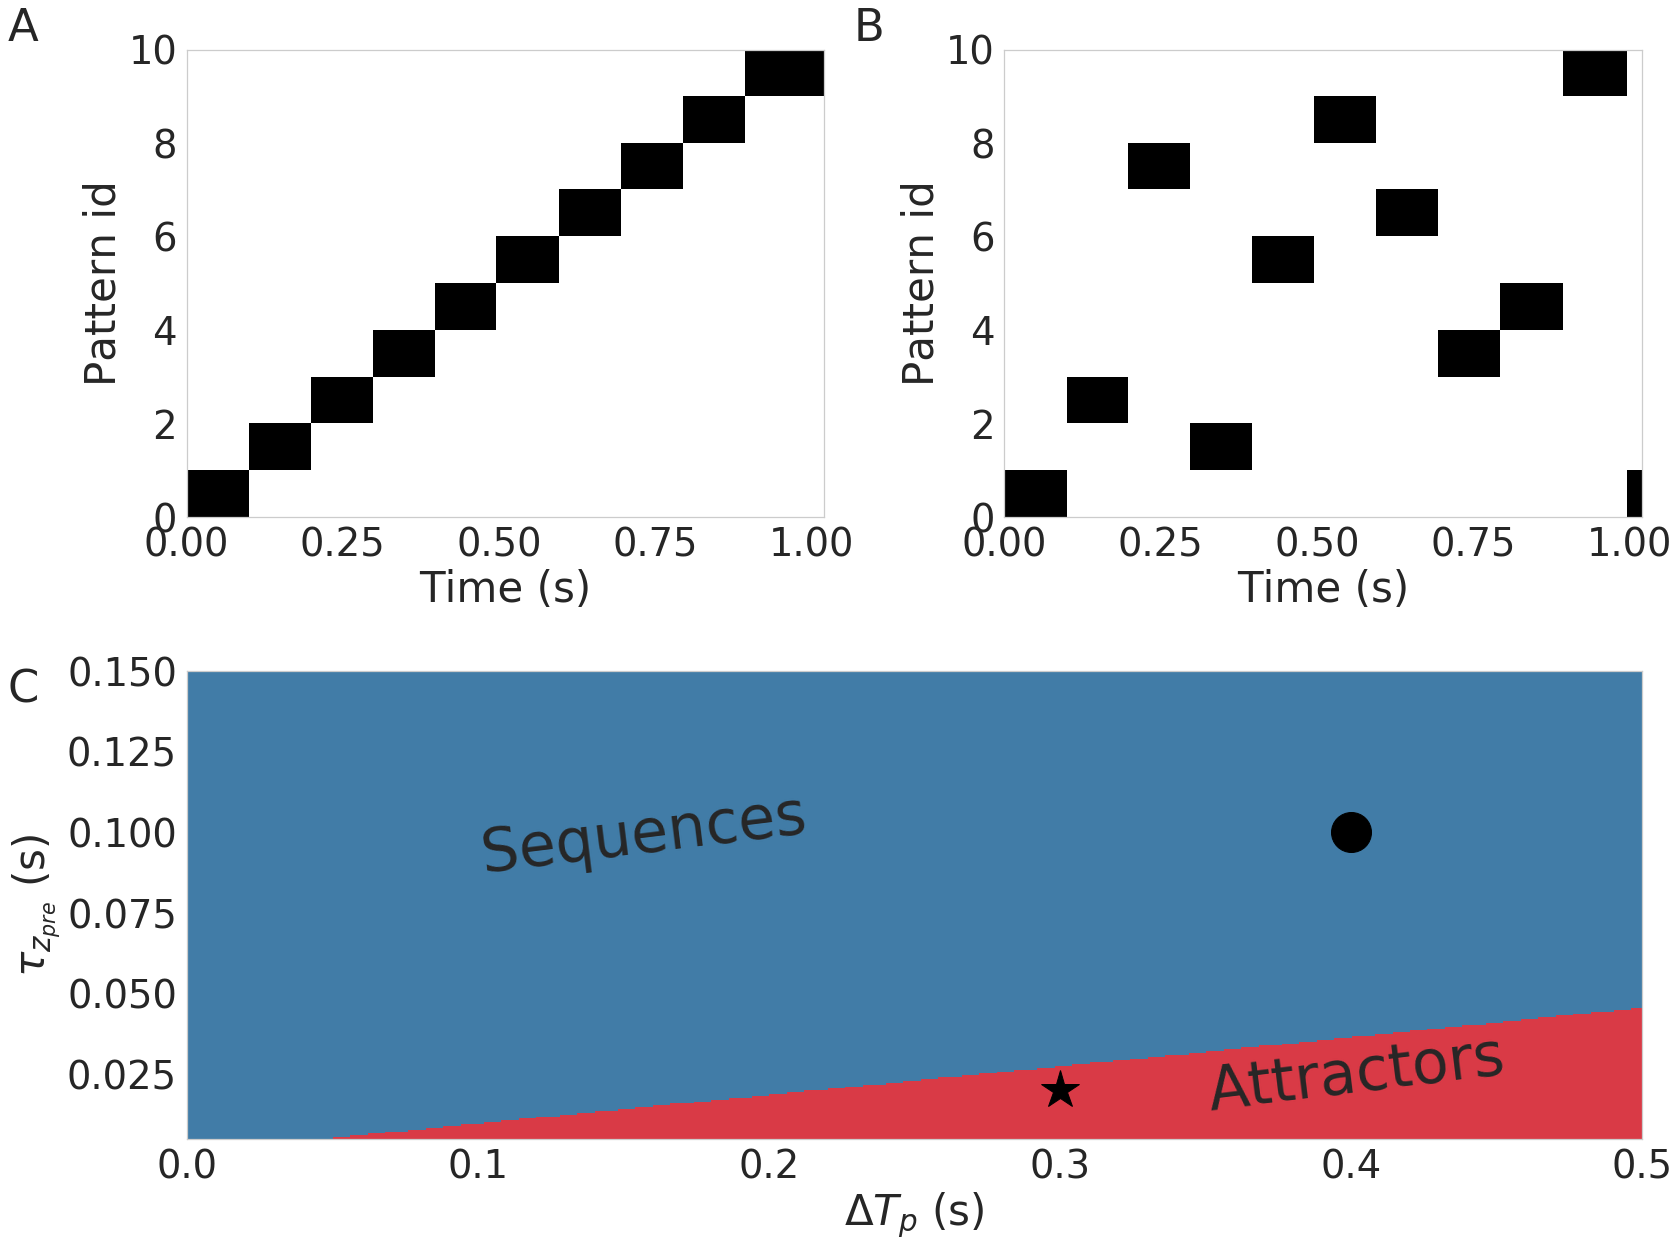

In [31]:
sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})

size_factor = 1.5
lw = 8
ms = 15
save = True
captions = True
size = 45
legend = False
gray = True
one_hypercolum = False
title = False
cmap = matplotlib.cm.binary

fig = plt.figure(figsize=(int(size_factor * 16), int(size_factor * 12)))
gs = gridspec.GridSpec(2, 2)

# First the matrix
ax = fig.add_subplot(gs[1, :])
cmap_square = sns.diverging_palette(240, 10, n=2, as_cmap=True)
extent = [ipi_vector[0], ipi_vector[-1], tau_z_pre_vector[0], tau_z_pre_vector[-1]]
im = ax.imshow(success_matrix.T, origin='lower', extent=extent, aspect='auto', cmap=cmap_square)
ax.set_xlabel(r'$\Delta T_p$ (s)')
ax.set_ylabel(r'$\tau_{z_{pre}}$ (s)')

angle = 7
ax.text(x=0.100, y=0.100, s='Sequences', rotation=angle, size=60)
ax.text(x=0.350, y=0.025, s='Attractors', rotation=angle, size=60)

ax.plot(ipi_point1, tau_z_point1, 'o', ms=ms + 25, color='black')
ax.plot(ipi_point2, tau_z_point2, '*', ms=ms + 25, color='black')
# ax.axvline(0.100, color='black', ls='--')

# The sequence side
ax1 = fig.add_subplot(gs[0, 0])
extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax1.imshow(O1.T, cmap=cmap, origin='lower', aspect='auto', extent=extent)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pattern id')
# ax1.plot(0.100, 8, 'o', ms=ms + 25, color='black')


# The attractor side
ax1 = fig.add_subplot(gs[0, 1])
extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax1.imshow(O2.T, cmap=cmap, origin='lower', aspect='auto', extent=extent)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pattern id')
ax1.axhline(minicolumns, ls='--', color='gray')

fig.tight_layout()

if captions:
    xpoint1 = 0.01
    xpoint2 = 0.50
    
    ypoint1 = 0.96
    ypoint2 = 0.45
    
    fig.text(xpoint1, ypoint1, 'A', size=size)
    fig.text(xpoint2, ypoint1, 'B', size=size)
    fig.text(xpoint1, ypoint2, 'C', size=size)


if save:
    directory = '../plot_producers/'
    file_name = 'attractor_vs_sequence' 
    format_string = '.pdf'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')